# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Обзор данных

На этом этапе мы получим самую общую информацию о данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)

In [5]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
messages = pd.read_csv('/datasets/messages.csv')

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
users = pd.read_csv('/datasets/users.csv')

In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
for i in [calls, internet, messages, tariffs, users]:
    print (i.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0

Все колонки, обозначающие дату, имеют тип _object_. Их нужно будет поменять на _datetime_. 

Пропуски имеются только в `churn_date` таблицы **`users`**. В этой колонке внесена дата прекращения пользования тарифом. Однако, нам известно, что пропущенные значения в этой колонке означают, что пользователь на момент выгрузки данных о тарифа не отказывался. 

После получения общей информации о данных, посмотрим на нее немного подробнее: изучим каждую таблицу по очереди и внесем необходимые изменения. 

## Подробное изучение всех таблиц и предобработка данных

### Таблица `calls`

In [13]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Нам необходимо привести `call_date` к формату _datetime_. Также, как нам известно из описания базы данных, длительность звонков оператор округляет в большую сторону - то есть 1 секунда разговора считается как минута. При этом, "нулевые" звонки - не ошибки в базе, а индикатор того, что звонок не состоялся. Со звонками продолжительностью 0 секунд ничего делать не нужно. 

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [15]:
calls['duration'].describe().round(1)

count    202607.0
mean          6.8
std           5.8
min           0.0
25%           1.3
50%           6.0
75%          10.7
max          38.0
Name: duration, dtype: float64

In [16]:
calls['duration'] = np.ceil(calls['duration'])

In [17]:
calls['duration'].describe().round(1)

count    202607.0
mean          7.2
std           6.0
min           0.0
25%           2.0
50%           6.0
75%          11.0
max          38.0
Name: duration, dtype: float64

После того, как мы привели длительность звонков к работе формату, необходимому для рассчета в рамках тарифов, можно рассмотреть длительность звонков чуть более подробно: посмотреть, как она распределяется

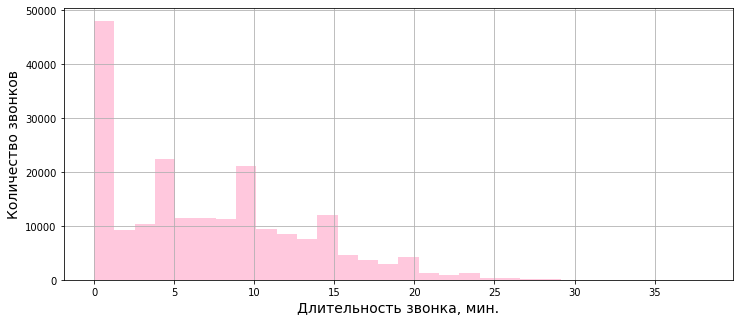

In [18]:
calls['duration'].hist(figsize=(12, 5), color='#ffc8dd', bins=30)
plt.xlabel('Длительность звонка, мин.', size=14)
plt.ylabel('Количество звонков', size=14)
plt.show()

In [19]:
cut_labels = ['звонок не состоялся', '1-3 минуты', '3-5 минут', '5-10 минут', '10-15 минут', '15-20 минут', 'более 20 минут']
cut_bins = [0, 0.9, 3, 5, 10, 15, 20, 39]
calls['duration_group'] = pd.cut(calls['duration'],
                       bins=cut_bins,
                       labels=cut_labels, include_lowest=True)

In [20]:
calls.head()

,id,call_date,duration,user_id,duration_group
0,1000_0,2018-07-25,0.0,1000,звонок не состоялся
1,1000_1,2018-08-17,0.0,1000,звонок не состоялся
2,1000_2,2018-06-11,3.0,1000,1-3 минуты
3,1000_3,2018-09-21,14.0,1000,10-15 минут
4,1000_4,2018-12-15,6.0,1000,5-10 минут


In [21]:
def freq(x): return '{:.1%} '.format(x.count()/len(calls))
calls.pivot_table(index='duration_group', values='duration', aggfunc=['mean', freq]).round(1)

,mean,freq
,duration,duration
duration_group,,
звонок не состоялся,0.0,19.6%
1-3 минуты,2.1,13.8%
3-5 минут,4.5,11.0%
5-10 минут,7.9,27.3%
10-15 минут,12.7,18.4%
15-20 минут,17.6,7.6%
более 20 минут,23.2,2.2%


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


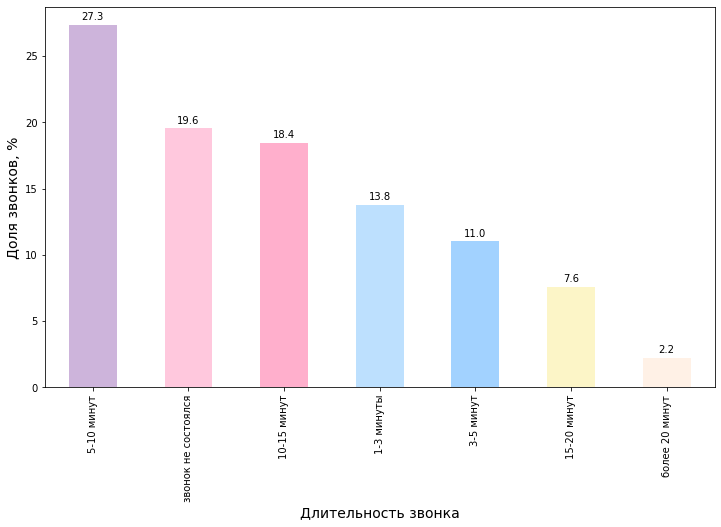

In [22]:
colors = ['#cdb4db', '#ffc8dd', '#ffafcc', '#bde0fe', '#a2d2ff', '#fcf5c7', '#fff1e6']

plot = calls['duration_group'].value_counts(normalize=True).mul(100).plot(
    kind='bar', figsize=(12, 7), colors=colors, legend=False)
for bar in plot.patches:
    plot.annotate(format(bar.get_height(), '.1f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10, xytext = (0, 8), 
                   textcoords = 'offset points')
plt.xlabel('Длительность звонка', size=14)
plt.ylabel('Доля звонков, %', size=14)
plt.show()

Практически каждый пятый звонок не получает ответа, вот они реалии последних лет. Однако, интересно отметить, что чуть более четверти звонков (а именно 27.3%) длятся от 5 до 10 минут: абонентам есть, о чем поговорить. Звонков длительностью 10-15 минут 18.4% в базе данных - даже больше, чем коротких звонков на 1-3 минуты (их 13.8%). 

### Таблица `internet`

In [23]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


В этой таблице нам также необходимо поработать с форматом в колонке `session_date`. Округлять `mb_used` сейчас не нужно: их мы будем округлять по пользователю за месяц. 

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

In [25]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [26]:
internet.query('mb_used == 0')

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


In [27]:
print (
'Количество интернет-сессий, в ходе которых было использовано 0MB интернет-трафика составляет', len(internet.query('mb_used == 0')['mb_used'])
)

print (
'Это {:.1%} от всех интернет сессий.'
.format(len(internet.query('mb_used == 0')['mb_used']) / len(internet['mb_used']))
)


Количество интернет-сессий, в ходе которых было использовано 0MB интернет-трафика составляет 19598
Это 13.1% от всех интернет сессий.


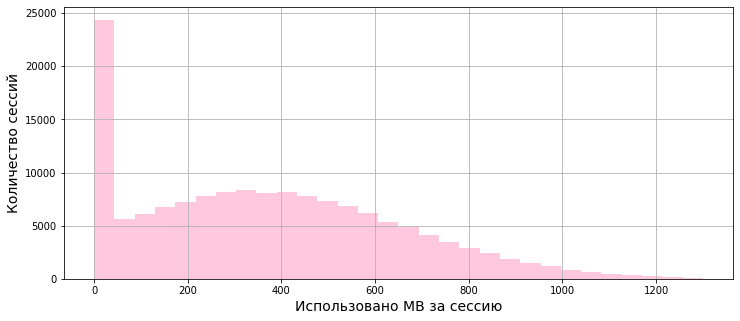

In [28]:
internet['mb_used'].hist(figsize=(12, 5), color='#ffc8dd', bins=30, range=(0, 1300))
plt.xlabel('Использовано MB за сессию', size=14)
plt.ylabel('Количество сессий', size=14)
plt.show()

In [29]:
print(
'В таблице "calls" можно обнаружить большой выброс: целых', internet.query('mb_used == 0')['mb_used'].count(), 
    'интернет-сессий, в течение которых было использовано 0 MB.'
)
print(
'Эти сессии составляют {:.1%} от всего количества сессий.'
.format(internet.query('mb_used == 0')['mb_used'].count()/len(internet['mb_used']))
)


В таблице "calls" можно обнаружить большой выброс: целых 19598 интернет-сессий, в течение которых было использовано 0 MB.
Эти сессии составляют 13.1% от всего количества сессий.


Эти "пустые" сессии могут значить что угодно. Можно предположить, что подобная сессия идет через соц. сети, которые считаются вне трафика по тарифу. 

Так или иначе, в рамках данного проекта, сессии, за которые пользователь потратил 0 MB, совершенно ни к чему: они не изменят месячной суммы трафика и, соответственно, никак не скажется на том, что мы исследуем - плате за тариф. Так что от этих строк мы можем спокойно избавиться. 

In [30]:
internet.drop(internet[internet['mb_used'] == 0].index, inplace=True)

In [31]:
internet.describe().round(2)

,mb_used,user_id
count,129798.00,129798.00
mean,426.09,1253.05
std,255.60,143.78
min,0.03,1000.00
25%,227.46,1132.00
50%,400.54,1252.00
75%,592.95,1380.00
max,1724.83,1499.00


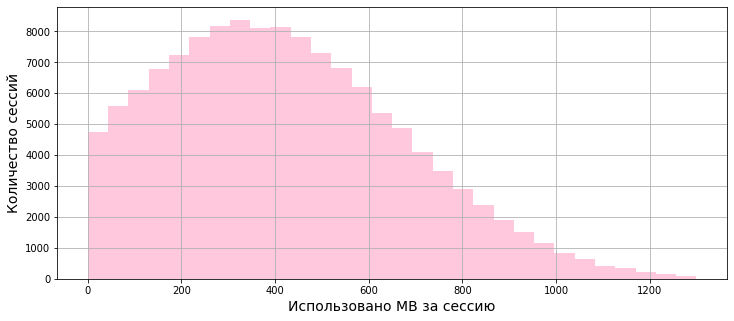

In [32]:
internet['mb_used'].hist(figsize=(12, 5), color='#ffc8dd', bins=30, range=(0, 1300))
plt.xlabel('Использовано MB за сессию', size=14)
plt.ylabel('Количество сессий', size=14)
plt.show()

Теперь распределение больше напоминает "купол". 

### Таблица `messages`

В этой таблице нам нужно только перевести `message_date` в формат _datetime_.

In [33]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [34]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Таблица `tariffs`

Эта таблица содержит основную информацию по тарифам "Мегалайна". Мы можем себе позволить немного изменить эту таблицу для того, чтобы она была удобнее при произведении рассчетов. 

Согласно условиям "Мегалайна", ежемесячный трафик округсяется до GB. В тарифы **smart** и **ultra** включены 15GB и 30GB в месяц соответственно. В таблице **`tariffs`** эти данные указаны в MB. Там будет проще обращаться к этой таблице, если это будет в GB.

In [35]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1000
tariffs['mb_per_month_included'] = np.floor(tariffs['mb_per_month_included'])

In [36]:
tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'}, inplace=True)

In [37]:
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


### Таблица `users`

Здесь можно найти информацию о пользователях. Колонки `reg_date` и `churn_date` нужно перевести в формат _datetime_. Также следует посмотреть на значения в колонках `age` и `city`, чтобы проверить, нет ли странных или выбивающихся значений.

In [38]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [39]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

In [40]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [41]:
users['age'].describe().round()

count    500.0
mean      47.0
std       17.0
min       18.0
25%       32.0
50%       46.0
75%       62.0
max       75.0
Name: age, dtype: float64

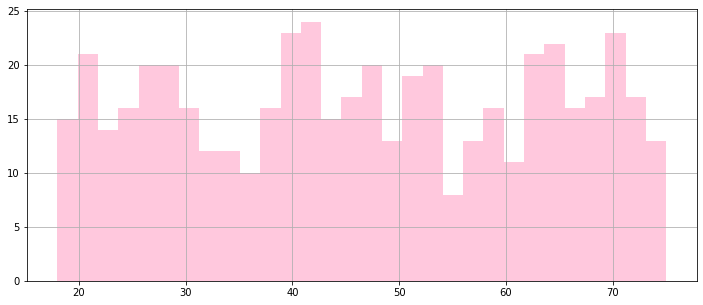

In [42]:
users['age'].hist(figsize=(12, 5), color='#ffc8dd', bins=30)
plt.show()

Детей и тысячелетних пользователей не обнаружено! 

In [43]:
sorted(users['city'].unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

In [44]:
def freq(x): return '{:.1%} '.format(x.count()/len(users))

users.groupby('city')['age'].agg(['count', freq]).sort_values(by='count', ascending=False).head(7).round(2)

,count,freq
city,,
Москва,99,19.8%
Санкт-Петербург,39,7.8%
Новосибирск,16,3.2%
Казань,14,2.8%
Омск,14,2.8%
Уфа,12,2.4%
Набережные Челны,11,2.2%


Названия городов сомнений не вызывают, распределение пользователей по городам - тоже. На первом месте ожидаемо Москва, на втором - Питер. За ними следуют крупнейшие города других регионов. 

### Промежуточные выводы

На этом этапе мы исправили тип данных в колонках, обозначающих время, с _object_ на _datetime_. Мы также отказались от строк с нулевым значением мегабайт в таблице **`internet`** - нам нечего делать с этмии данными в рамках проекта. 
Пропущенные значения имеются только в колонке `churn_date` таблицы **`users`**, однако с этими данными нам ничего не нужно делать, так как эта колонка обозначает дату прекращения пользования тарифом.

## Расчеты и объединение таблиц

### Количество сделанных звонков и израсходованных минут в месяц по пользователям

In [45]:
calls.query('user_id == 1000')['duration'].count()

368

In [46]:
calls['month_year'] = calls['call_date'].astype('datetime64[M]')

In [47]:
df = calls.groupby(by=['user_id','month_year'])['duration'].agg(['count', 'sum']).reset_index()

In [48]:
df.columns = ['user_id', 'month_year', 'calls_per_month_count', 'calls_per_month_duration']

In [49]:
df.head()

,user_id,month_year,calls_per_month_count,calls_per_month_duration
0,1000,2018-05-01,22,159.0
1,1000,2018-06-01,43,172.0
2,1000,2018-07-01,47,340.0
3,1000,2018-08-01,52,408.0
4,1000,2018-09-01,58,466.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
user_id                     3174 non-null int64
month_year                  3174 non-null datetime64[ns]
calls_per_month_count       3174 non-null int64
calls_per_month_duration    3174 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 99.3 KB


Мы рассчитали количество звонков и минут разговора по месяцам для каждого пользователя. Таблицу с этмми данными мы назвали **`df`** для того, чтобы к ней в будущем присоединить колонки из аналогичных таблиц с подсчетами сообщений и интернет-трафика. 

### Количество отправленных сообщений по месяцам

In [51]:
messages['month_year'] = messages['message_date'].astype('datetime64[M]')

In [52]:
messages_per_month = messages.groupby(by=['user_id','month_year'])['user_id'].agg(['count']).reset_index()

In [53]:
messages_per_month.columns = ['user_id', 'month_year', 'messages_per_month']

In [54]:
messages_per_month.head()

,user_id,month_year,messages_per_month
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


### Объем израсходованного интернет-трафика по месяцам

In [55]:
internet['month_year'] = internet['session_date'].astype('datetime64[M]')

In [56]:
traffic_per_month = internet.groupby(by=['user_id','month_year'])['mb_used'].agg(['sum']).reset_index()

Мегабайты лучше сразу перевести в гигабайты, поскольку все подсчеты дажее будут именно в них. 

In [57]:
traffic_per_month.columns = ['user_id', 'month_year', 'gbs_per_month']

In [58]:
traffic_per_month['gbs_per_month'] = traffic_per_month['gbs_per_month']/1024

Также, согласно условиям оператора, месячный трафик округляется в бо'льшую сторону. Проделаем это с колонкой `gbs_per_month`.

In [59]:
traffic_per_month['gbs_per_month'] = np.ceil(traffic_per_month['gbs_per_month'])

In [60]:
traffic_per_month.head()

,user_id,month_year,gbs_per_month
0,1000,2018-05-01,3.0
1,1000,2018-06-01,23.0
2,1000,2018-07-01,14.0
3,1000,2018-08-01,14.0
4,1000,2018-09-01,15.0


### Объединение всей необходимой информации в таблицу `df`

In [61]:
df = df.merge(messages_per_month, on=['user_id', 'month_year'], how='outer')
df = df.merge(traffic_per_month, on=['user_id', 'month_year'], how='outer')
df = df.merge(users, on='user_id', how='left')

In [62]:
df.head()

,user_id,month_year,calls_per_month_count,calls_per_month_duration,messages_per_month,gbs_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id                     3214 non-null int64
month_year                  3214 non-null datetime64[ns]
calls_per_month_count       3174 non-null float64
calls_per_month_duration    3174 non-null float64
messages_per_month          2717 non-null float64
gbs_per_month               3201 non-null float64
age                         3214 non-null int64
churn_date                  187 non-null datetime64[ns]
city                        3214 non-null object
first_name                  3214 non-null object
last_name                   3214 non-null object
reg_date                    3214 non-null datetime64[ns]
tariff                      3214 non-null object
dtypes: datetime64[ns](3), float64(4), int64(2), object(4)
memory usage: 351.5+ KB


In [64]:
df[df['messages_per_month'].isna()].head()

,user_id,month_year,calls_per_month_count,calls_per_month_duration,messages_per_month,gbs_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
8,1001,2018-11-01,59.0,430.0,NaN,18.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,2018-12-01,63.0,414.0,NaN,14.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
42,1006,2018-02-01,3.0,42.0,NaN,2.0,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
43,1006,2018-03-01,46.0,286.0,NaN,17.0,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
44,1006,2018-04-01,47.0,356.0,NaN,14.0,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart


Мы видим пропущенные значения в колонке `messages_per_month` у разных пользователей. Это может означать только одно: в такие месяца эти пользователи не отправляли смс-сообщения. Эти _NaN_ стоит заменить на нулевые значения. 

In [65]:
df['messages_per_month'] = df['messages_per_month'].fillna(0)

Можно также заметить пропущенные значение в колонках `calls_per_month_count` и `calls_per_month_duration`.

In [66]:
df[df['calls_per_month_duration'].isna()].head()

,user_id,month_year,calls_per_month_count,calls_per_month_duration,messages_per_month,gbs_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
3174,1091,2018-05-01,NaN,NaN,30.0,11.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
3175,1091,2018-06-01,NaN,NaN,30.0,10.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
3176,1091,2018-07-01,NaN,NaN,35.0,17.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
3177,1091,2018-08-01,NaN,NaN,31.0,13.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
3178,1091,2018-09-01,NaN,NaN,32.0,17.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra


In [67]:
print('Можно обнаружить, что в этих колонках пропуски пересекаются.')
print('Соответственно, можно предположить, что существуют пользователи, которые попросту не пользуются звонками:')
print('возможно, они звонят через мессенжеры или не пользуются жтим телефоном для звонков вовсе.')
print('Таких пользователей всего', len(df[df['calls_per_month_duration'].isna()]['user_id'].unique()))

Можно обнаружить, что в этих колонках пропуски пересекаются.
Соответственно, можно предположить, что существуют пользователи, которые попросту не пользуются звонками:
возможно, они звонят через мессенжеры или не пользуются жтим телефоном для звонков вовсе.
Таких пользователей всего 8


В данном случае мы можем себе позволить заменить NaN на нулевые значения, как и в ситуации с смс-сообщениями. 

In [68]:
df['calls_per_month_count'] = df['calls_per_month_count'].fillna(0)
df['calls_per_month_duration'] = df['calls_per_month_duration'].fillna(0)

Пропуски остаются в `gbs_per_month`.

In [69]:
df[df['gbs_per_month'].isna()].head()

,user_id,month_year,calls_per_month_count,calls_per_month_duration,messages_per_month,gbs_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
584,1094,2018-05-01,16.0,107.0,3.0,NaN,37,NaT,Новосибирск,Даниэла,Пугачева,2018-05-28,ultra
1697,1273,2018-05-01,24.0,220.0,21.0,NaN,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
1698,1273,2018-06-01,40.0,230.0,38.0,NaN,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
1699,1273,2018-07-01,44.0,253.0,37.0,NaN,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
1700,1273,2018-08-01,53.0,253.0,41.0,NaN,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra


In [70]:
print ('Таких пропусков всего', len(df[df['gbs_per_month'].isna()]))
print('При этом, остальные данные по данным пользователям за данный период у нас имеются.')
print('Можно также предположить, что эти пользователи не использовали мобильный интернет, а пользовались телефоном для звонков и сообщений.')
print ('Этих пользователей всего', len(df[df['gbs_per_month'].isna()]['user_id'].unique()))

Таких пропусков всего 13
При этом, остальные данные по данным пользователям за данный период у нас имеются.
Можно также предположить, что эти пользователи не использовали мобильный интернет, а пользовались телефоном для звонков и сообщений.
Этих пользователей всего 6


Заменяем пропуски на нулевые значения!

In [71]:
df['gbs_per_month'] = df['gbs_per_month'].fillna(0)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id                     3214 non-null int64
month_year                  3214 non-null datetime64[ns]
calls_per_month_count       3214 non-null float64
calls_per_month_duration    3214 non-null float64
messages_per_month          3214 non-null float64
gbs_per_month               3214 non-null float64
age                         3214 non-null int64
churn_date                  187 non-null datetime64[ns]
city                        3214 non-null object
first_name                  3214 non-null object
last_name                   3214 non-null object
reg_date                    3214 non-null datetime64[ns]
tariff                      3214 non-null object
dtypes: datetime64[ns](3), float64(4), int64(2), object(4)
memory usage: 351.5+ KB


Пропущенные значения остаются только в `churn_date`, где указана дата прекращения пользования тарифов. Эти пропуски нам заполнять не нужно. 

**Теперь у нас есть база данных `df`, в которой нет пропущенных значенийи и собраны основные данные пользователей:**
* идентификатор пользователя
* количество звонков в месяц
* суммарная длительность разговоров за месяц
* количество смс за месяц
* количество израсходованных мегайбайт интернета за месяц
* имя, фамилия, возраст и город пользователя

Далее мы можем провести необходимые расчеты, пользуясь этой базой данных.

### Расчет помесячной выручки с каждого пользователя

Мы располагаем необходимой информацией по тарифам _**Smart**_ и _**Ultra**_:

**Тариф Smart**:
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
** минута разговора: 3 рубля
** сообщение: 3 рубля
** 1 Гб интернет-трафика: 200 рублей

**Тариф Ultra**:
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
** минута разговора: 1 рубль
** сообщение: 1 рубль
** 1 Гб интернет-трафика: 150 рублей

Эта же информация описана в таблице **`tariffs`**.

In [73]:
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Имея в распоряжении эти данные, мы можем подсчитать, какую прибыль "Мегалайн" получила каждый месяц от каждого пользователя. 

In [74]:
def monthly_profit(row):
    minutes=row['calls_per_month_duration']
    messages=row['messages_per_month']
    gbs=row['gbs_per_month']
    tariff=row['tariff']
    
    if tariff=='smart':
        monthly_profit=550
        if minutes>500:
            extra_minutes=minutes-500
            monthly_profit+=extra_minutes*3
        if messages>50:
            extra_messages=messages-50
            monthly_profit+=extra_messages*3
        if gbs>15:
            extra_traffic=gbs-15
            monthly_profit+=extra_traffic*200
    else:
        monthly_profit=1950
        if minutes>3000:
            extra_minutes=minutes-3000
            monthly_profit+=extra_minutes*1
        if messages>1000:
            extra_messages=messages-1000
            monthly_profit+=extra_messages*1
        if gbs>30:
            extra_traffic=gbs-30
            monthly_profit+=extra_traffic*150
    return monthly_profit

In [75]:
df['monthly_profit'] = df.apply(monthly_profit, axis=1)

In [76]:
df.head(10)

,user_id,month_year,calls_per_month_count,calls_per_month_duration,messages_per_month,gbs_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,monthly_profit
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
5,1000,2018-10-01,57.0,350.0,73.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
6,1000,2018-11-01,43.0,338.0,58.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
7,1000,2018-12-01,46.0,333.0,70.0,10.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
8,1001,2018-11-01,59.0,430.0,0.0,18.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,1150.0
9,1001,2018-12-01,63.0,414.0,0.0,14.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,550.0


### Промежуточные выводы

**В ходе данного этапа была рассчитана помесячная выручка с каждого пользователя из имеющейся выборки на основе условий тарифов оператора.**

## Анализ данных

На этапе анализа данных мы изучим показатели количества минут, сообщений и GB интернета для пользователей тарифов "Смарт" и "Ультра". Также рассмотрим ежемесячную выручку оператора "Мегалайн".

In [77]:
df.pivot_table(
    index=['tariff'], 
    values=['calls_per_month_duration', 'messages_per_month', 'gbs_per_month', 'monthly_profit'],
    aggfunc= {'calls_per_month_duration': [np.mean, np.median, np.var, np.std],
            'messages_per_month': [np.mean, np.median, np.var, np.std],
            'gbs_per_month': [np.mean, np.median, np.var, np.std],
             'monthly_profit': [np.mean, np.median, np.var, np.std]}
).round(2)

calls_per_month_duration                           gbs_per_month  \
                           mean median     std        var          mean   
tariff                                                                    
smart                    417.93  422.0  190.31   36219.32         16.33   
ultra                    526.62  518.0  317.61  100873.63         19.49   

                           messages_per_month                         \
       median   std    var               mean median    std      var   
tariff                                                                 
smart    17.0  5.75  33.03              33.38   28.0  28.23   796.81   
ultra    19.0  9.85  97.09              49.36   38.0  47.80  2285.27   

       monthly_profit                             
                 mean  median     std        var  
tariff                                            
smart         1289.97  1023.0  818.40  669785.71  
ultra         2070.15  1950.0  376.19  141516.75

Мы видим, что в среднем и по медиане пользователи не выходят за лимиты минут в месяц - 500 минут для тарифа "Смарт" и 3000 минут для тарифа "Ультра". Однако, стоит отметить, что пользователи тарифа "Ультра" недобирают свои минуты: в среднем в месяц общаясь по 527 минут из доступных 3000, а по медиане и того меньше. Разумеется, есть пользователи, которые общаются выше среднего, и об этом говорят большие дисперсия и стандартное отклонение.

В тарифы "Смарт" и "Ультра" входят 15 и 30GB интернет-трафика соотвественно. И в среднем (16.33GB), и по медиане (17GB) пользователи "Смарта" из этого пакета выходят. А средние и медианные пользователи тарифа "Ультра" опять недобирают: 19.49GB и 19GB при высоких значениям дисперсии и стандартного отклонения (кому-то все же удается пользоваться тарифом "по полной"). 

Из 50 для "Смарта" и 1000 для "Ультра" сообщений, включенных в пакет, пользователи первого тарифа в среднем используют 33, а второго - 49. Несмотря на высокие диперсию и стандартное отклонение, можно заявить, что пользователи тарифа "Ультра", входящие в данную выборку, не нуждаются в 1000 смс-сообщений в месяц. 

Что же касается ежемесячной платы по тарифу, при условии, что пользователь не выходит за пределы пакета, он платит 550 рублей за "Смарт" и 1950 рублей за "Ультра". Можно наблюдать, что пользователи "Ультра" редко выходят за пределы: 1950 рублей - медианное значение, среднее (2070 рублей) не так далеко от медианы. А вот пользователи "Смарта" в среднем платят в 2 раза больше стоимости тарифа - 1290 рублей, а по медиане - 1023 рубля. Это неудивительно, так как многие из них превышают лимит на интернет-трафик. 

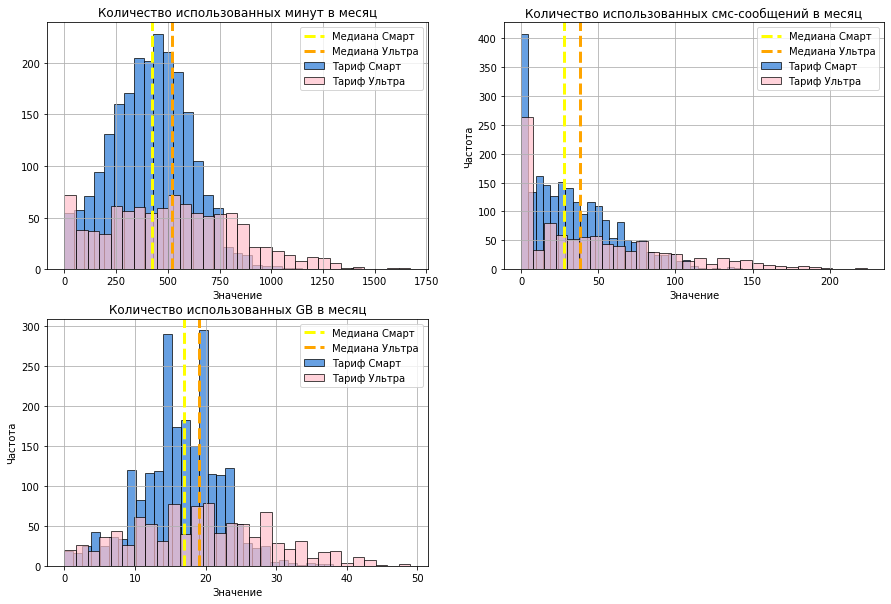

In [112]:
smart=df[(df['tariff'] == 'smart')]
ultra=df[(df['tariff'] == 'ultra')]

fig=plt.figure()

ax_1=fig.add_subplot(2, 2, 1)
plt.hist(smart['calls_per_month_duration'], bins=30, alpha=0.7, edgecolor='black', color='#2678D7')
plt.hist(ultra['calls_per_month_duration'], bins=30, alpha=0.7, edgecolor='black', color='pink')
plt.axvline(x=smart['calls_per_month_duration'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=ultra['calls_per_month_duration'].median(),linewidth=3, color='orange', linestyle='--')
plt.grid()
plt.xlabel('Значение')
plt.legend(['Медиана Смарт', 'Медиана Ультра','Тариф Смарт', 'Тариф Ультра'])
plt.title('Количество использованных минут в месяц')

ax_2=fig.add_subplot(2, 2, 2)
plt.hist(smart['messages_per_month'], bins=30, alpha=0.7, edgecolor='black', color='#2678D7')
plt.hist(ultra['messages_per_month'], bins=30, alpha=0.7, edgecolor='black', color='pink')
plt.axvline(x=smart['messages_per_month'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=ultra['messages_per_month'].median(),linewidth=3, color='orange', linestyle='--')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid()
plt.legend(['Медиана Смарт', 'Медиана Ультра','Тариф Смарт', 'Тариф Ультра'])
plt.title('Количество использованных смс-сообщений в месяц')

ax_3=fig.add_subplot(2, 2, 3)
plt.hist(smart['gbs_per_month'], bins=30, alpha=0.7, edgecolor='black', color='#2678D7')
plt.hist(ultra['gbs_per_month'], bins=30, alpha=0.7, edgecolor='black', color='pink')
plt.axvline(x=smart['gbs_per_month'].median(),linewidth=3, color='yellow', linestyle='--')
plt.axvline(x=ultra['gbs_per_month'].median(),linewidth=3, color='orange', linestyle='--')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid()
plt.legend(['Медиана Смарт', 'Медиана Ультра','Тариф Смарт', 'Тариф Ультра'])
plt.title('Количество использованных GB в месяц')


plt.gcf().set_size_inches(15, 10)
plt.show()

По гистограммам наглядно видно:
* чуть меньше половинны пользователей "Смарта" выходят за лимит минут в рамках пакета
* никто из пользователей "Ультра" в нашей выборке не "наговаривает" 3000 минут в месяц
* многие пользователи обоих тарифов практически не пишут смс-сообщения, но в обоих тарифах есть те, кто выходит за пределы лимита
* пользователи "Смарта" часто выходят за пределы пакета GB, причем могут выходить за эти пределы достаточно сильно - наблюдается пик около 23GB/месяц (из 15GB, включенных в тариф)
* пользователи "Ультра" выходят за пределы включенных в тариф GB (у них 30GB) значительно реже

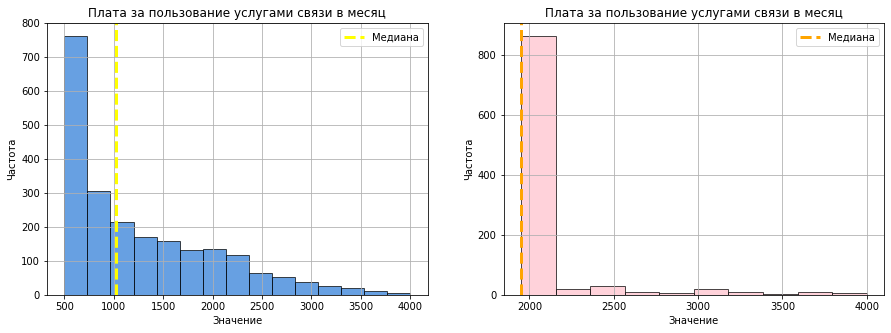

In [119]:
fig=plt.figure()

ax_1=fig.add_subplot(1, 2, 1)
plt.hist(smart['monthly_profit'], bins=15, alpha=0.7, edgecolor='black', color='#2678D7', range=(500,4000))
plt.axvline(x=smart['monthly_profit'].median(),linewidth=3, color='yellow', linestyle='--')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid()
plt.legend(['Медиана'])
plt.title('Плата за пользование услугами связи в месяц')

ax_1=fig.add_subplot(1, 2, 2)
plt.hist(ultra['monthly_profit'], bins=10, alpha=0.7, edgecolor='black', color='pink', range=(1950,4000))
plt.axvline(x=ultra['monthly_profit'].median(),linewidth=3, color='orange', linestyle='--')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid()
plt.legend(['Медиана'])
plt.title('Плата за пользование услугами связи в месяц')


plt.gcf().set_size_inches(15, 5)
plt.show()


Гистограмма подтверждает, что большинство пользователей тарифа "Ультра" не выходит за пределы пакета и платит 1950 рублей в месяц. 
Что же касается тех, кто использует "Смарт", здесь значительная часть пользователей платит гораздо больше дефолтных 500 рублей. 

### Промежуточные выводы

**Можно предположить, что средним пользователям обоих тарифов эти тарифы не очень подходят:**
* пользователям тарифа "Смарт" хоть и в среднем достаточно минут для звонков, они нуждаются в большем количестве интернет-трафика; они переплачивают почти в 2 раза из-за того, что не укладываются в лимиты
* а пользователи "Ультра" не нуждаются в таким количестве минут и смс, да и трафика для них в среднем многовато; они переплачивают из-за того, что такие количество услуг им попросту ненужно

**Также можно высказать предположение, что данные тарифы можно несколько видоизменить под нужды их пользователей или предложить им перейти на другие существующие тарифы, так как пользователи могут найти более выгодное предложение у конкурентов.** 

## Проверка гипотез

### Гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

Примем нулевую гипотезу H0 о равенстве средней выручки пользователей этих двух тарифов. 
Альтернативной гипотезой H1, соответственно, будет гипотеза о том, что средняя выручка пользователей двух тарифов не равна. 

Проверим гипотезу при помощи t-теста. 

Уровень статистической значимости _alpha_ установим 0.05. 

In [80]:
alpha=.05
results=st.ttest_ind(smart['monthly_profit'], ultra['monthly_profit'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Полученное нами _p-value_ в разы ниже уровня статистической значимости _alpha_. Это говорит о том, что **гипотезу о равенстве средних мы в данном случае отвергаем и может предположить, что для имеющихся данных средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются.**

Этот результат подтверждают рассмотренные нами ранее средние значения и распределения значений `monthly_profit` для двух тарифов. Несмотря на то, что пользователи "Смарта" переплачивают и часто выходят за пределы пакета стоимостью 500 рублей, пользователи "Ультра" в большинстве случаев платят стоимость пакета (1950 рублей) без дополнительных услуг. 

### Гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Примем нулевую гипотезу H0 о равенстве средней выручки пользователей из Москвы и других регионов. Альтернативной гипотезой H1 будет гипотеза об отсутсвии этого равенства. Проверим гипотезу при помощи t-теста. 

Уровень статистической значимости _alpha_ установим 0.05. 

In [81]:
moscow = df[(df['city'] == 'Москва')]['monthly_profit']
not_moscow = df[(df['city'] != 'Москва')]['monthly_profit']

In [82]:
alpha=.05
results=st.ttest_ind(moscow, not_moscow)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


In [83]:
moscow.agg([np.mean, np.median, np.std]).round(2)

mean      1546.71
median    1750.00
std        752.09
Name: monthly_profit, dtype: float64

In [84]:
not_moscow.agg([np.mean, np.median, np.std]).round(2)

mean      1524.94
median    1583.00
std        808.79
Name: monthly_profit, dtype: float64

В данном случае у нас не получилось отвергнуть нулевую гипотезу. 

**Соответственно, мы можем предположить, что средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов.**

### Промежуточные выводы

В ходе данного этапа мы отвергли гипотезу о равенстве средней выручки пользователей двух тарифов: вероятнее всего, средняя выручка пользователей "Смарта" и "Ультра" различаются. 
Нам не удалось отвергнуть гипотезу о равенстве средней выручки пользователей из Москвы и других регионов: вероятнее всего, средняя выручка в Москве и за ее пределами не различается. 

## Общие выводы

Был проведен анализ тарифов "Смарт" и "Ультра" компании "Мегалайн". 

В ходе этапа анализа и предобработки данных были изучены таблицы **`calls`, `internet`, `messages`, `tariffs`, `users`**. 

В таблицах не было пропущенных значений, кроме значения прекращения действия тарифа в **`users`**, которое является отметкой, что пользователь сменил тарифный план в определеннуб дату. Эти нулевые значения мы не удаляли и не заполняли. 
Нулевые значения были удалены из таблицы **`internet`**: для анализа в рамках данного проекта интернет-сессии, в которых не было использовано ни одного MB трафика, не являются необходимой информацией. Доля значений, которые были удалены из таблицы **`internet`** - 13.1%. Нулевые значения в других таблицах означали, что пользователь в определенный промежуток времени (мы рассчитывали по месяцам) не пользовался определенной услугой (это видно по смс-сообщениям). 

Из исходных таблиц была сформирована база данных **`df`** с необходимой для проведения рассчетов информацией. В эту таблицу была добавлена колонка `monthly_profit`, в которой мы указали стоимость услуг для каждого клиента в месяц в зависимости от особенностей тарифов. 

Проанализировав данные, мы пришли к выводу, что пользователи тарифа "Смарт" зачастую выходят за пределы пакета и, соотвественно, вынуждены платить сверх установленной для этого тарифы суммы (550 рублей в месяц). В среднем они платят 1290 рублей, используя 419 минут (из 500 минут в пакете), 16.3GB интернета (из 15GB в пакете) и 33.4 смс-сообщения (из 50 смс в пакете). Так, чаще всего пользователи "Смарта" оплачивают дополнительные GB интернета (200 рублей/GB) и, таким образом, в среднем выходит, что они платят в 2 раза больше дефолтной суммы тарифа. 

Что же касается пользователей тарифа "Ультра", они, напротив, "недобирают" входящие в тарифный пакет услуги: в среднем они используют 545 минут (из 3000 минут в пакете), 19.7GB (из 30GB в пакете) и 49 смс (из 1000 смс в пакете). В среднем, пользователи "Ультра" платят 2070 рублей при дефолтной плате в 1950 рублей, однако медианным значением здесь является именно 1950 рублей, что говорит о том, что большиство пользователей не выходят за лимиты, установленные тарифом. 

Проект включал проверку двух гипотез: 
* гипотеза о том, что средняя выручка пользователей тарифов "Смарт" и "Ультра" различается - **не можем отвергнуть**
* гипотеза о том, что средняя выручка пользователей из Москвы и других регионов различается - **можем отвергнуть**

По итогам исследования можно предположить, что для "Мегалайна" более выгоден тариф "Ультра" ввиду того, что он включает в себя большой пакет звонков, смс и интернет-трафика, которые большинство пользователей на 100% не использует. В отличии от "Смарта", пользователи которого с большой регулярностью выходят за лимиты. 
Тем не менее, если формулировать рекомендацию на базе проведенного исследования, можно предположить, что для "Мегалайна" стоит рассмотреть варианты изменений:
* изменить пакеты существующих тарифов в соответствии с поведением пользователей
* предложить пользователям другие существующие тарифы "Мегалайна", которые более соответствуют их поведению

Это может быть полезным, так как нельзя отрицать такой ситуации, что пользователи могут предпочесть более подходящие им тарифы у операторов-конкурентов. Возможно, имеет смысл рассмотреть эти или другие варианты изменений и проанализировать их. 